<a href="https://colab.research.google.com/github/SergeiVKalinin/MSE_Fall2024/blob/main/Module_6/21_ReinforcementLearning3x4.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Tutorial notebook for the Fall 2024 course "Introduction to ML for Materials Science"
- Instructor: Sergei V. Kalinin
- Adapted (added visualization functions and value calculation) from: https://mpatacchiola.github.io/blog/2017/01/15/dissecting-reinforcement-learning-2.html

Experiment with the reinforcement learning in the slippery 3x4 frozen lake environment. Here, we will define the environment with one wall and 2 terminal states with reward +1 (success) and -1 (failure) respectively. We also intorduce the cost of each step. We can explore with what happens if:
- the cost of step is large and negative
- cost of step is small and negative
- cost of step is small and positive
- cost of step is large and positive
(In fact, there are multiple regimes even in this siimple system, but I keep detailed exploratiion for the midterm).

The first cell defines the GridWorld environment.

In [1]:
# @title
#MIT License
#Copyright (c) 2017 Massimiliano Patacchiola
#
#Permission is hereby granted, free of charge, to any person obtaining a copy
#of this software and associated documentation files (the "Software"), to deal
#in the Software without restriction, including without limitation the rights
#to use, copy, modify, merge, publish, distribute, sublicense, and/or sell
#copies of the Software, and to permit persons to whom the Software is
#furnished to do so, subject to the following conditions:
#
#The above copyright notice and this permission notice shall be included in all
#copies or substantial portions of the Software.
#
#THE SOFTWARE IS PROVIDED "AS IS", WITHOUT WARRANTY OF ANY KIND, EXPRESS OR
#IMPLIED, INCLUDING BUT NOT LIMITED TO THE WARRANTIES OF MERCHANTABILITY,
#FITNESS FOR A PARTICULAR PURPOSE AND NONINFRINGEMENT. IN NO EVENT SHALL THE
#AUTHORS OR COPYRIGHT HOLDERS BE LIABLE FOR ANY CLAIM, DAMAGES OR OTHER
#LIABILITY, WHETHER IN AN ACTION OF CONTRACT, TORT OR OTHERWISE, ARISING FROM,
#OUT OF OR IN CONNECTION WITH THE SOFTWARE OR THE USE OR OTHER DEALINGS IN THE
#SOFTWARE.

#Class for creating a gridworld of arbitrary size and with arbitrary obstacles.
#Each state of the gridworld should have a reward. The transition matrix is defined
#as the probability of executing an action given a command to the robot.

import numpy as np

class GridWorld:

    def __init__(self, tot_row, tot_col):
        self.action_space_size = 4
        self.world_row = tot_row
        self.world_col = tot_col
        #The world is a matrix of size row x col x 2
        #The first layer contains the obstacles
        #The second layer contains the rewards
        #self.world_matrix = np.zeros((tot_row, tot_col, 2))
        self.transition_matrix = np.ones((self.action_space_size, self.action_space_size))/ self.action_space_size
        #self.transition_array = np.ones(self.action_space_size) / self.action_space_size
        self.reward_matrix = np.zeros((tot_row, tot_col))
        self.state_matrix = np.zeros((tot_row, tot_col))
        self.position = [np.random.randint(tot_row), np.random.randint(tot_col)]

    #def setTransitionArray(self, transition_array):
        #if(transition_array.shape != self.transition_array):
            #raise ValueError('The shape of the two matrices must be the same.')
        #self.transition_array = transition_array

    def setTransitionMatrix(self, transition_matrix):
        '''Set the reward matrix.

        The transition matrix here is intended as a matrix which has a line
        for each action and the element of the row are the probabilities to
        executes each action when a command is given. For example:
        [[0.55, 0.25, 0.10, 0.10]
         [0.25, 0.25, 0.25, 0.25]
         [0.30, 0.20, 0.40, 0.10]
         [0.10, 0.20, 0.10, 0.60]]

        This matrix defines the transition rules for all the 4 possible actions.
        The first row corresponds to the probabilities of executing each one of
        the 4 actions when the policy orders to the robot to go UP. In this case
        the transition model says that with a probability of 0.55 the robot will
        go UP, with a probaiblity of 0.25 RIGHT, 0.10 DOWN and 0.10 LEFT.
        '''
        if(transition_matrix.shape != self.transition_matrix.shape):
            raise ValueError('The shape of the two matrices must be the same.')
        self.transition_matrix = transition_matrix

    def setRewardMatrix(self, reward_matrix):
        '''Set the reward matrix.

        '''
        if(reward_matrix.shape != self.reward_matrix.shape):
            raise ValueError('The shape of the matrix does not match with the shape of the world.')
        self.reward_matrix = reward_matrix

    def setStateMatrix(self, state_matrix):
        '''Set the obstacles in the world.

        The input to the function is a matrix with the
        same size of the world
        -1 for states which are not walkable.
        +1 for terminal states
         0 for all the walkable states (non terminal)
        The following matrix represents the 4x3 world
        used in the series "dissecting reinforcement learning"
        [[0,  0,  0, +1]
         [0, -1,  0, +1]
         [0,  0,  0,  0]]
        '''
        if(state_matrix.shape != self.state_matrix.shape):
            raise ValueError('The shape of the matrix does not match with the shape of the world.')
        self.state_matrix = state_matrix

    def setPosition(self, index_row=None, index_col=None):
        ''' Set the position of the robot in a specific state.

        '''
        if(index_row is None or index_col is None): self.position = [np.random.randint(tot_row), np.random.randint(tot_col)]
        else: self.position = [index_row, index_col]

    def render(self):
        ''' Print the current world in the terminal.

        O represents the robot position
        - respresent empty states.
        # represents obstacles
        * represents terminal states
        '''
        graph = ""
        for row in range(self.world_row):
            row_string = ""
            for col in range(self.world_col):
                if(self.position == [row, col]): row_string += u" \u25CB " # u" \u25CC "
                else:
                    if(self.state_matrix[row, col] == 0): row_string += ' - '
                    elif(self.state_matrix[row, col] == -1): row_string += ' # '
                    elif(self.state_matrix[row, col] == +1): row_string += ' * '
            row_string += '\n'
            graph += row_string
        print(graph)

    def reset(self, exploring_starts=False):
        ''' Set the position of the robot in the bottom left corner.

        It returns the first observation
        '''
        if exploring_starts:
            while(True):
                row = np.random.randint(0, self.world_row)
                col = np.random.randint(0, self.world_col)
                if(self.state_matrix[row, col] == 0): break
            self.position = [row, col]
        else:
            self.position = [self.world_row-1, 0]
        #reward = self.reward_matrix[self.position[0], self.position[1]]
        return self.position

    def step(self, action):
        ''' One step in the world.

        [observation, reward, done = env.step(action)]
        The robot moves one step in the world based on the action given.
        The action can be 0=UP, 1=RIGHT, 2=DOWN, 3=LEFT
        @return observation the position of the robot after the step
        @return reward the reward associated with the next state
        @return done True if the state is terminal
        '''
        if(action >= self.action_space_size):
            raise ValueError('The action is not included in the action space.')

        #Based on the current action and the probability derived
        #from the trasition model it chooses a new actio to perform
        action = np.random.choice(4, 1, p=self.transition_matrix[int(action),:])
        #action = self.transition_model(action)

        #Generating a new position based on the current position and action
        if(action == 0): new_position = [self.position[0]-1, self.position[1]]   #UP
        elif(action == 1): new_position = [self.position[0], self.position[1]+1] #RIGHT
        elif(action == 2): new_position = [self.position[0]+1, self.position[1]] #DOWN
        elif(action == 3): new_position = [self.position[0], self.position[1]-1] #LEFT
        else: raise ValueError('The action is not included in the action space.')

        #Check if the new position is a valid position
        #print(self.state_matrix)
        if (new_position[0]>=0 and new_position[0]<self.world_row):
            if(new_position[1]>=0 and new_position[1]<self.world_col):
                if(self.state_matrix[new_position[0], new_position[1]] != -1):
                    self.position = new_position

        reward = self.reward_matrix[self.position[0], self.position[1]]
        #Done is True if the state is a terminal state
        done = bool(self.state_matrix[self.position[0], self.position[1]])
        return self.position, reward, done

This code define the plotting and visualization functions. It is modified to remove the original print_policy function

In [2]:
# @title
#MIT License
#Copyright (c) 2017 Massimiliano Patacchiola
#
#Permission is hereby granted, free of charge, to any person obtaining a copy
#of this software and associated documentation files (the "Software"), to deal
#in the Software without restriction, including without limitation the rights
#to use, copy, modify, merge, publish, distribute, sublicense, and/or sell
#copies of the Software, and to permit persons to whom the Software is
#furnished to do so, subject to the following conditions:
#
#The above copyright notice and this permission notice shall be included in all
#copies or substantial portions of the Software.
#
#THE SOFTWARE IS PROVIDED "AS IS", WITHOUT WARRANTY OF ANY KIND, EXPRESS OR
#IMPLIED, INCLUDING BUT NOT LIMITED TO THE WARRANTIES OF MERCHANTABILITY,
#FITNESS FOR A PARTICULAR PURPOSE AND NONINFRINGEMENT. IN NO EVENT SHALL THE
#AUTHORS OR COPYRIGHT HOLDERS BE LIABLE FOR ANY CLAIM, DAMAGES OR OTHER
#LIABILITY, WHETHER IN AN ACTION OF CONTRACT, TORT OR OTHERWISE, ARISING FROM,
#OUT OF OR IN CONNECTION WITH THE SOFTWARE OR THE USE OR OTHER DEALINGS IN THE
#SOFTWARE.

#Example of Monte Carlo methods for control.
#In this example I will use the class gridworld to generate a 3x4 world
#in which the cleaning robot will move. Using the Monte Carlo method I
#will estimate the policy and the state-action matrix of each state.

import numpy as np
import matplotlib.pyplot as plt
from matplotlib import colors

def get_return(state_list, gamma):
    '''Get the return for a list of action-state values.

    @return get the Return
    '''
    counter = 0
    return_value = 0
    for visit in state_list:
        # (observation, action, reward ) = visit
        _, _, reward = visit
        return_value += reward * np.power(gamma, counter)
        counter += 1
    return return_value

def update_policy(episode_list, policy_matrix, state_action_matrix):
    '''Update a policy making it greedy in respect of the state-action matrix.

    @return the updated policy
    '''
    for visit in episode_list:
        # (observation, action, reward ) = visit
        observation, _, _ = visit
        col = observation[1] + (observation[0]*4)
        if(policy_matrix[observation[0], observation[1]] != -1):
            policy_matrix[observation[0], observation[1]] = \
                np.argmax(state_action_matrix[:,col])
    return policy_matrix


Here, we define a new function for visualization of policy, and calculate value and define function for visualization of value

In [3]:
# @title
def print_policy(policy_matrix, reward_matrix, state_matrix):

    # Define the grid shape
    shape = policy_matrix.shape

    # Create a color map for the grid
    cmap = colors.ListedColormap(['white', 'black', 'red', 'blue'])  # white: empty, black: walls, red: bad, blue: goal

    # Create a base grid where each value is 0 (white)
    grid = np.zeros(shape)

    # Mark walls, goals, and bad states based on policy_matrix, reward_matrix, and state_matrix
    for row in range(shape[0]):
        for col in range(shape[1]):
            if np.isnan(policy_matrix[row, col]):  # Walls (NaN values in policy_matrix)
                grid[row, col] = 1  # Black for walls
            elif state_matrix[row, col] != 0:  # Consider non-zero state elements
                if reward_matrix[row, col] > 0:  # Positive reward (goal)
                    grid[row, col] = 3  # Blue for positive end states
                elif reward_matrix[row, col] < 0:  # Negative reward (bad state)
                    grid[row, col] = 2  # Red for negative end states

    # Plot the grid
    fig, ax = plt.subplots()
    ax.imshow(grid, cmap=cmap)

    # Define the directions for policies: ^, >, v, <
    directions = {
        0: '↑',  # Up
        1: '→',  # Right
        2: '↓',  # Down
        3: '←'   # Left
    }

    # Add arrows for policies
    for row in range(shape[0]):
        for col in range(shape[1]):
            if policy_matrix[row, col] == -1 or np.isnan(policy_matrix[row, col]) or (state_matrix[row, col] != 0 and reward_matrix[row, col] != 0):
                continue  # Skip terminal states, walls, and end states
            action = policy_matrix[row, col]
            ax.text(col, row, directions[action], va='center', ha='center', fontsize=18, color='black')

    # Set gridlines
    ax.set_xticks(np.arange(-0.5, shape[1], 1), minor=True)
    ax.set_yticks(np.arange(-0.5, shape[0], 1), minor=True)
    ax.grid(which="minor", color="gray", linestyle='-', linewidth=2)

    # Turn off axis labels
    ax.set_xticks([])
    ax.set_yticks([])

    plt.show()

def calculate_value_matrix(state_action_matrix):
    """
    Calculate the value matrix by averaging over actions for each state.
    :param state_action_matrix: The state-action matrix
    :return: The value matrix (averaging over actions for each state)
    """
    # Average over the actions for each state (columns correspond to states, rows correspond to actions)
    value_matrix = np.mean(state_action_matrix, axis=0)
    return value_matrix.reshape(3, 4)  # Reshape to the grid size (3x4 in your case)

# Function to visualize value matrix with numbers superimposed (same as provided earlier)


def plot_value_matrix(V, reward_matrix, state_matrix, title="Value Matrix"):
    """
    Plots the value matrix as a heatmap with numbers superimposed.
    Does not display numbers where state_matrix is non-zero.
    Shows black cells for state_matrix == -1.
    Shows reward_matrix elements for state_matrix == 1.
    :param V: The value matrix (2D numpy array)
    :param reward_matrix: The matrix of rewards (to show in certain cells)
    :param state_matrix: The matrix of state types (to control display)
    :param title: The title of the plot
    """
    fig, ax = plt.subplots(figsize=(8, 6))

    # Create a masked array for the heatmap to avoid showing obstacles (-1) and end states (1)
    masked_V = np.ma.masked_where(state_matrix != 0, V)  # Mask areas where state_matrix != 0
    cax = ax.matshow(masked_V, cmap='coolwarm')  # Plot only valid areas

    # Add colorbar
    plt.colorbar(cax)

    # Loop over data dimensions and create text annotations for valid states
    for i in range(V.shape[0]):
        for j in range(V.shape[1]):
            # If state_matrix is 0, show the value from V
            if state_matrix[i, j] == 0:
                ax.text(j, i, f'{V[i, j]:.2f}', ha='center', va='center', color='black')
            # If state_matrix is -1, show black cells (obstacles)
            elif state_matrix[i, j] == -1:
                ax.add_patch(plt.Rectangle((j-0.5, i-0.5), 1, 1, fill=True, color='black'))
            # If state_matrix is 1, show the reward_matrix value
            elif state_matrix[i, j] == 1:
                ax.text(j, i, f'{reward_matrix[i, j]:.2f}', ha='center', va='center', color='red')

    # Set gridlines
    ax.set_xticks(np.arange(-0.5, V.shape[1], 1), minor=True)
    ax.set_yticks(np.arange(-0.5, V.shape[0], 1), minor=True)
    ax.grid(which="minor", color="black", linestyle='-', linewidth=2)

    # Hide x and y ticks
    ax.set_xticks([])
    ax.set_yticks([])

    plt.title(title)
    plt.show()


Now, we are getting to the real RL. We define the elements of the:
- state_matrix, i.e. the wall and terminal states,
- reward_matrix, i.e. rewards in terminal state (+1 for success and -1 for failure)
= transition_matrix, that defines slipperiness of the floor (main diagonal elements mean the probability of intended action if we try to perform it, and off-diagonal are probability of unintended actions)

State Matrix:
[[ 0.  0.  0.  1.]
 [ 0. -1.  0.  1.]
 [ 0.  0.  0.  0.]]
Reward Matrix:
[[-0.04 -0.04 -0.04  1.  ]
 [-0.04 -0.04 -0.04 -1.  ]
 [-0.04 -0.04 -0.04 -0.04]]

Policy matrix after 1 iterations:


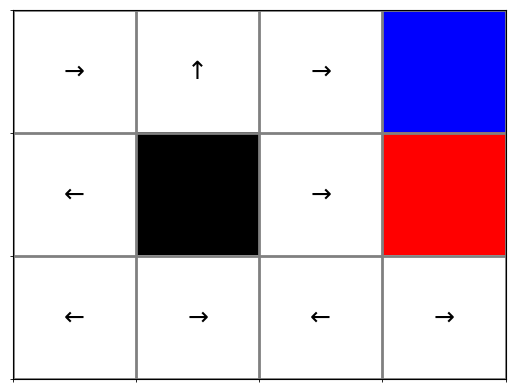

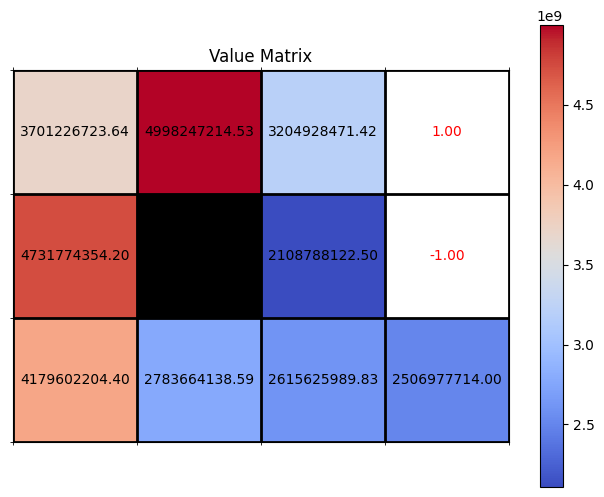


Policy matrix after 501 iterations:


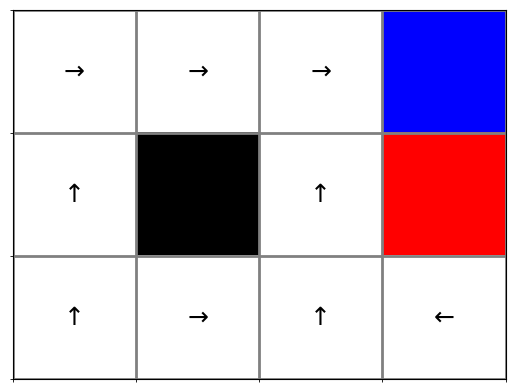

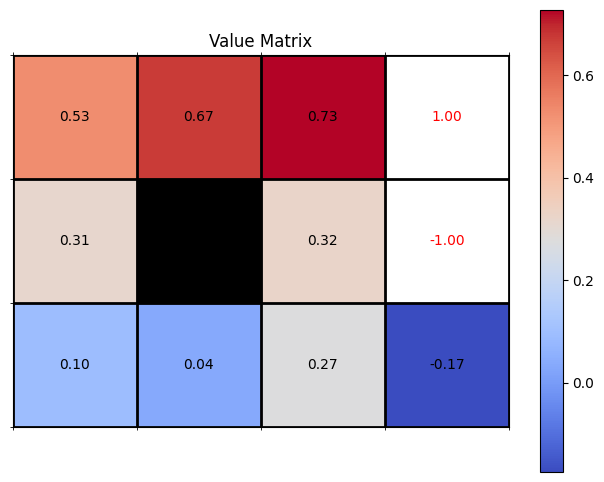


Policy matrix after 1001 iterations:


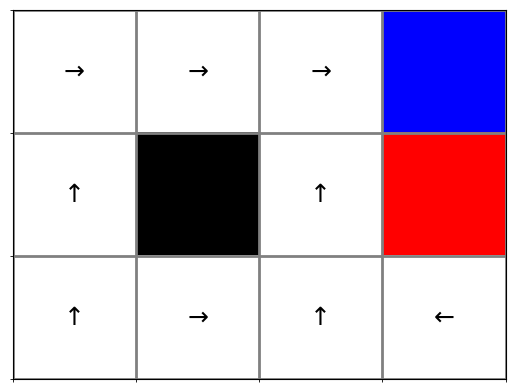

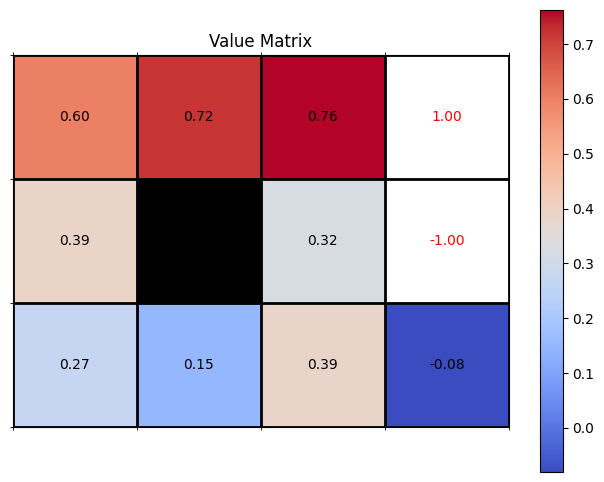


Policy matrix after 1501 iterations:


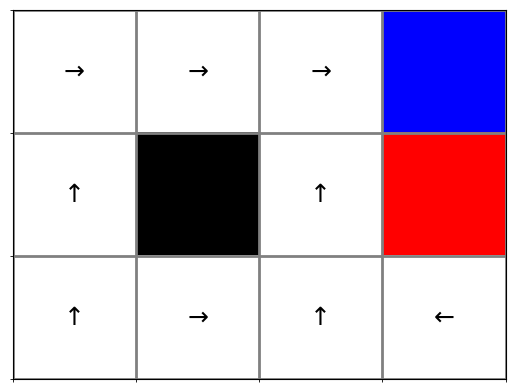

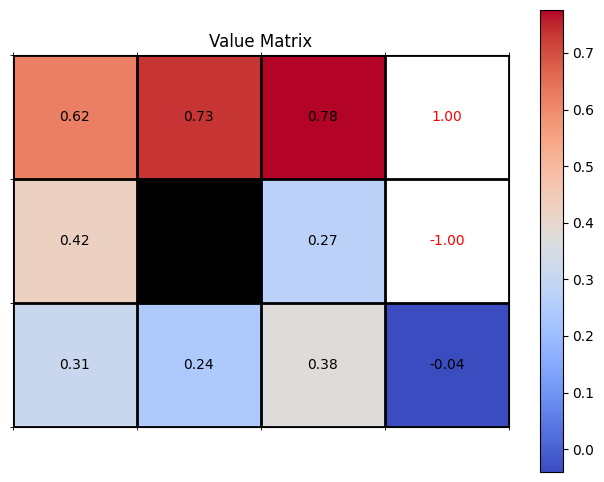


Policy matrix after 2001 iterations:


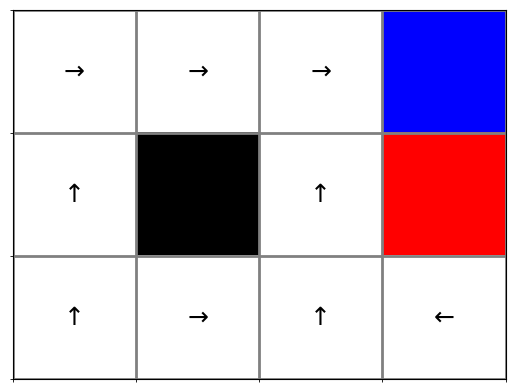

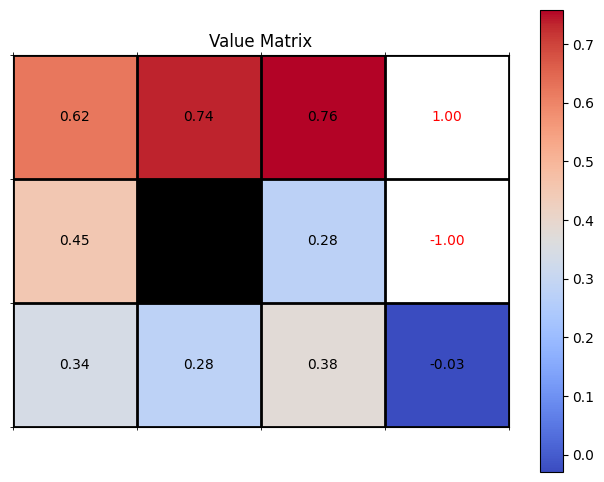


Policy matrix after 2501 iterations:


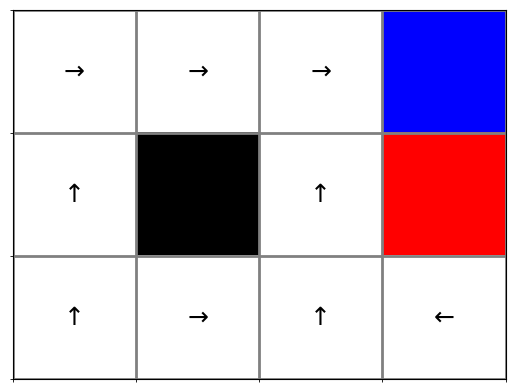

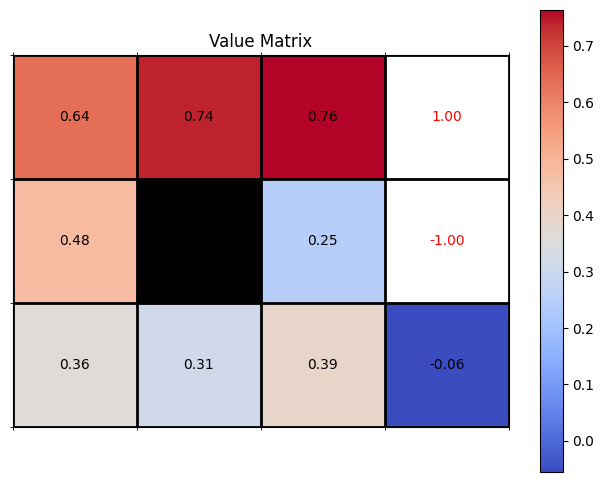


Policy matrix after 3001 iterations:


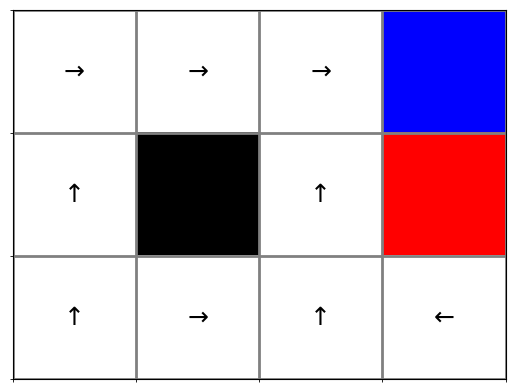

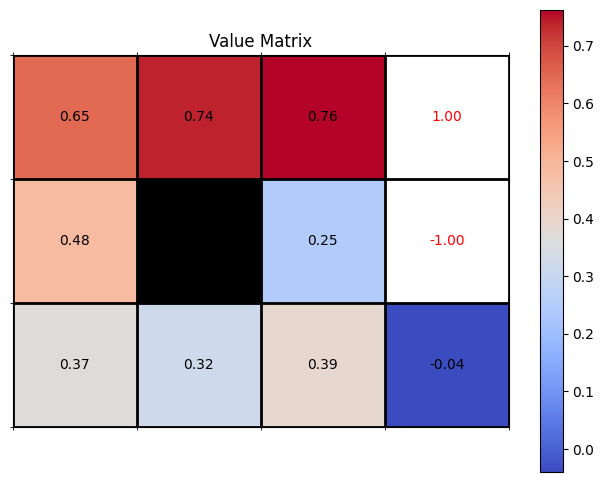


Policy matrix after 3501 iterations:


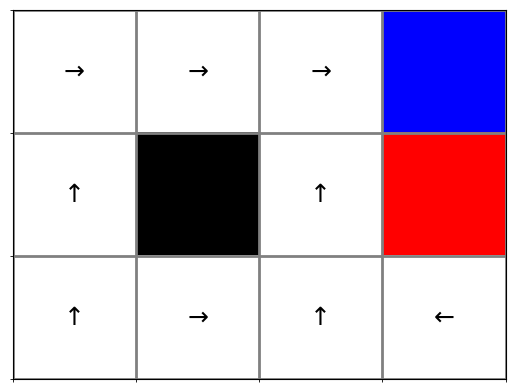

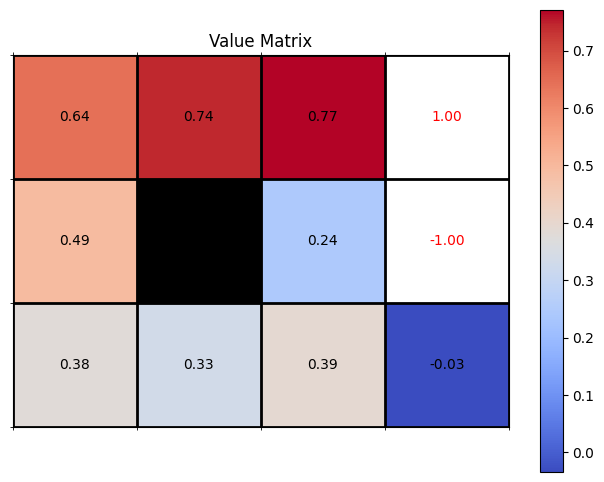


Policy matrix after 4001 iterations:


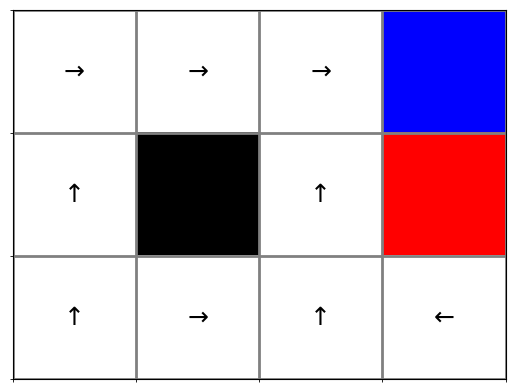

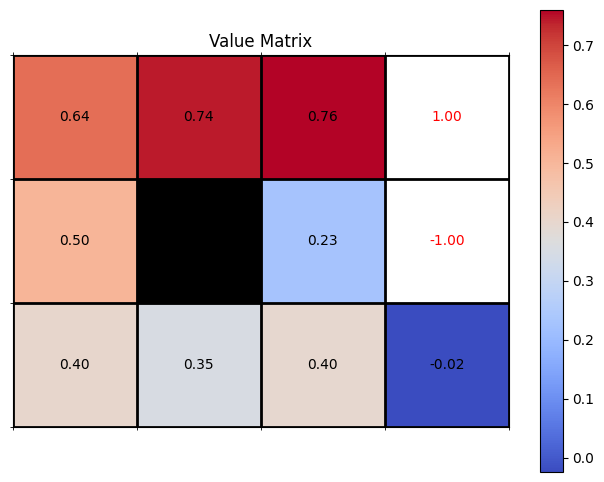


Policy matrix after 4501 iterations:


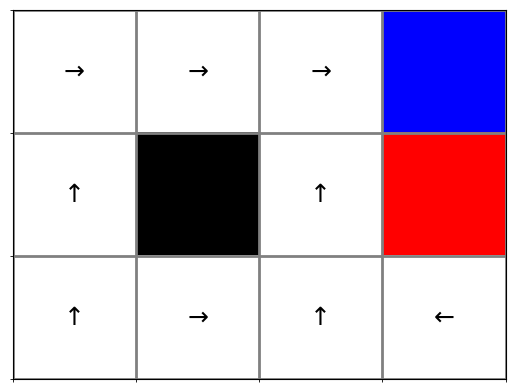

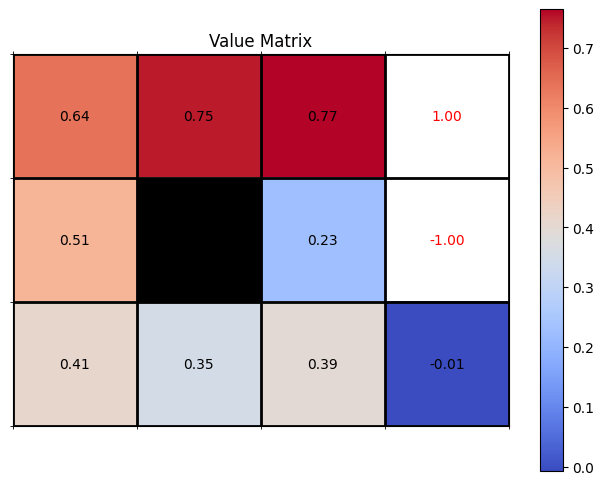

Utility matrix after 5000 iterations:
[[ 6.63219517e-01  7.51200696e-01  8.30586532e-01  7.98835661e+09
   6.25229222e-01  6.56646580e+09  6.30103963e-01  7.00407557e+09
   5.12985872e-01  3.42916458e-01  5.08972733e-01 -7.88092653e-01]
 [ 7.15593952e-01  8.31499847e-01  9.40914520e-01  2.80001835e+09
   4.82406401e-01  8.31977361e+09 -5.64547712e-01  6.20752710e+09
   3.47649551e-01  4.04997088e-01  3.73890459e-01  1.22872299e-01]
 [ 5.76826322e-01  7.44019606e-01  5.87423578e-01  5.63120105e+09
   4.25679475e-01  4.02864796e+09  3.29605402e-01  2.23736735e+09
   4.17084839e-01  2.53832831e-01  3.56656801e-01  2.53808924e-01]
 [ 5.88018362e-01  6.61767282e-01  7.01419706e-01  8.04252942e+09
   5.17430526e-01  2.40767905e+09  5.64228089e-01  4.85305597e+09
   3.84308531e-01  4.20605348e-01  3.35241879e-01  3.29209311e-01]]


In [4]:
def main():

    env = GridWorld(3, 4)

    #Define the state matrix
    state_matrix = np.zeros((3,4))
    state_matrix[0, 3] = 1
    state_matrix[1, 3] = 1
    state_matrix[1, 1] = -1
    print("State Matrix:")
    print(state_matrix)

    #Define the reward matrix
    reward_matrix = np.full((3,4), -0.04) #-0.04
    reward_matrix[0, 3] = 1
    reward_matrix[1, 3] = -1
    print("Reward Matrix:")
    print(reward_matrix)

    #Define the transition matrix
    transition_matrix = np.array([[0.8, 0.1, 0.0, 0.1],
                                  [0.1, 0.8, 0.1, 0.0],
                                  [0.0, 0.1, 0.8, 0.1],
                                  [0.1, 0.0, 0.1, 0.8]])

    #Random policy
    policy_matrix = np.random.randint(low=0, high=4, size=(3, 4)).astype(np.float32)
    policy_matrix[1,1] = np.NaN #NaN for the obstacle at (1,1)
    policy_matrix[0,3] = policy_matrix[1,3] = -1 #No action for the terminal states

    #Set the matrices in the world
    env.setStateMatrix(state_matrix)
    env.setRewardMatrix(reward_matrix)
    env.setTransitionMatrix(transition_matrix)

    state_action_matrix = np.random.random_sample((4,12)) # Q
    #init with 1.0e-10 to avoid division by zero
    running_mean_matrix = np.full((4,12), 1.0e-10)
    gamma = 0.95
    tot_epoch = 5000
    print_epoch = 500

    for epoch in range(tot_epoch):
        #Starting a new episode
        episode_list = list()
        #Reset and return the first observation and reward
        observation = env.reset(exploring_starts=True)
        #action = np.random.choice(4, 1)
        #action = policy_matrix[observation[0], observation[1]]
        #episode_list.append((observation, action, reward))
        is_starting = True
        for _ in range(1000):
            #Take the action from the action matrix
            action = policy_matrix[observation[0], observation[1]]
            #If the episode just started then it is
                #necessary to choose a random action (exploring starts)
            if(is_starting):
                action = np.random.randint(0, 4)
                is_starting = False
            #Move one step in the environment and get obs and reward
            new_observation, reward, done = env.step(action)
            #Append the visit in the episode list
            episode_list.append((observation, action, reward))
            observation = new_observation
            if done: break
        #The episode is finished, now estimating the utilities
        counter = 0
        #Checkup to identify if it is the first visit to a state
        checkup_matrix = np.zeros((4,12))
        #This cycle is the implementation of First-Visit MC.
        #For each state stored in the episode list check if it
        #is the rist visit and then estimate the return.
        for visit in episode_list:
            observation, action, reward = visit
            col = int(observation[1] + (observation[0]*4))
            row = int(action)
            if(checkup_matrix[row, col] == 0):
                return_value = get_return(episode_list[counter:], gamma)
                running_mean_matrix[row, col] += 1
                state_action_matrix[row, col] += return_value
                checkup_matrix[row, col] = 1
            counter += 1
        #Policy Update
        policy_matrix = update_policy(episode_list,
                                      policy_matrix,
                                      state_action_matrix/running_mean_matrix)

        # After the simulation has completed and the state-action matrix is populated:
        value_matrix = calculate_value_matrix(state_action_matrix / running_mean_matrix)

        #Printing
        if(epoch % print_epoch == 0):
            print("")
            #print("State-Action matrix after " + str(epoch+1) + " iterations:")
            #print(state_action_matrix / running_mean_matrix)
            print("Policy matrix after " + str(epoch+1) + " iterations:")
            #print(policy_matrix)
            print_policy(policy_matrix, reward_matrix, state_matrix)
            plot_value_matrix(value_matrix, reward_matrix, state_matrix, title="Value Matrix")
    #Time to check the utility matrix obtained
    print("Utility matrix after " + str(tot_epoch) + " iterations:")
    print(state_action_matrix / running_mean_matrix)


if __name__ == "__main__":
    main()

Now, experiment with the reward for the step. You will see that:
- If the cost of step is large and negative (-2), the robot goes to the nearest terminal state as fast as possible (even if it is negative). Effectively, it commits suicide
- If the cost is -1, it tries to get positive outcome for some initial starting points
- If the cost of step is small and negative (-0.04), robot discovers the positive end goal
- If the cost of step is small and positive (0.05) it explores towards positive goal
- But if the cost of step is large and positive (1), the robot just goes in curcuits.

Conclusion: it matters whether you are paid to do the job, or have the job done!